In [ ]:
#import necessary libraries
import pandas as pd
import numpy as np
import pyarrow
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, roc_auc_score as ras, roc_curve, auc, accuracy_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# reading test data
test_df= pd.read_parquet('/content/drive/MyDrive/test.parquet', engine= 'pyarrow')
print(test_df.head(2))

                            Patient-Uid       Date        Incident
0  a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f 2016-12-08  SYMPTOM_TYPE_0
1  a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f 2018-10-17     DRUG_TYPE_0


In [ ]:
# reading train data
train_df= pd.read_parquet('/content/drive/MyDrive/train.parquet', engine= 'pyarrow')
print(train_df.head(2))

                            Patient-Uid       Date           Incident
0  a0db1e73-1c7c-11ec-ae39-16262ee38c7f 2019-03-09  PRIMARY_DIAGNOSIS
1  a0dc93f2-1c7c-11ec-9cd2-16262ee38c7f 2015-05-16  PRIMARY_DIAGNOSIS


In [ ]:
#checking of train dataset(row x columns)
train_df.shape

(3220868, 3)

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1065524 entries, 0 to 1372859
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Patient-Uid  1065524 non-null  object        
 1   Date         1065524 non-null  datetime64[ns]
 2   Incident     1065524 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 32.5+ MB


In [ ]:
# checking unique values
train_df.nunique()

Patient-Uid    27033
Date            1977
Incident          57
dtype: int64

In [ ]:
#cheking null values
train_df.isna().sum()

Patient-Uid    0
Date           0
Incident       0
dtype: int64

In [ ]:
# droping duplicate rows
train_df.drop_duplicates(inplace=True)
# checking data size after droping duplicates
train_df.shape

(3185297, 3)

In [ ]:
# generating positive set
positive_df = train_df[train_df['Incident']=='TARGET DRUG']
positive_df.head(2)

,Patient-Uid,Date,Incident
3294791,a0eb742b-1c7c-11ec-8f61-16262ee38c7f,2020-04-09,TARGET DRUG
3296990,a0edaf09-1c7c-11ec-a360-16262ee38c7f,2018-06-12,TARGET DRUG


In [ ]:
# shape of positive set
positive_df.shape

(67218, 3)

In [ ]:
negative =  train_df[~train_df['Patient-Uid'].isin(positive_df['Patient-Uid'])]
negative_df = negative.groupby('Patient-Uid').tail(1)
negative_df

,Patient-Uid,Date,Incident
1560892,a0e3a8c0-1c7c-11ec-98c2-16262ee38c7f,2018-05-06,PRIMARY_DIAGNOSIS
1620903,a0dd6a3f-1c7c-11ec-9b86-16262ee38c7f,2015-04-07,SYMPTOM_TYPE_0
1629044,a0e48a75-1c7c-11ec-8c5f-16262ee38c7f,2018-08-22,DRUG_TYPE_6
1942882,a0e3cf61-1c7c-11ec-8098-16262ee38c7f,2018-08-21,DRUG_TYPE_2
1975541,a0e91a8c-1c7c-11ec-acc2-16262ee38c7f,2020-04-15,PRIMARY_DIAGNOSIS
...,...,...,...
3256795,a0e045a1-1c7c-11ec-8014-16262ee38c7f,2020-07-10,PRIMARY_DIAGNOSIS
3256799,a0e67e2a-1c7c-11ec-b805-16262ee38c7f,2015-12-16,PRIMARY_DIAGNOSIS
3256800,a0dec400-1c7c-11ec-80df-16262ee38c7f,2019-08-06,PRIMARY_DIAGNOSIS
3256804,a0e09919-1c7c-11ec-9e7d-16262ee38c7f,2017-02-19,DRUG_TYPE_6


In [ ]:
# shape of negative set
negative_df.shape

(17659, 3)

In [ ]:
# to get the count of previous prescriptions within specific time intervals
positive_df['Prescription_Count'] = positive_df.groupby('Patient-Uid')['Date'].cumcount()
negative_df['Prescription_Count'] = negative_df.groupby('Patient-Uid')['Date'].cumcount()
positive_df.tail(5)

,Patient-Uid,Date,Incident,Prescription_Count
29074998,a0ef2b6d-1c7c-11ec-9172-16262ee38c7f,2018-10-12,TARGET DRUG,4
29075105,a0ebe423-1c7c-11ec-a5e0-16262ee38c7f,2019-07-02,TARGET DRUG,9
29075494,a0ebc713-1c7c-11ec-bd53-16262ee38c7f,2019-05-21,TARGET DRUG,10
29080031,a0ee1bdb-1c7c-11ec-90ba-16262ee38c7f,2018-06-07,TARGET DRUG,14
29080178,a0eef180-1c7c-11ec-8de8-16262ee38c7f,2018-07-17,TARGET DRUG,13


In [ ]:
negative_df.tail()

,Patient-Uid,Date,Incident,Prescription_Count
3256795,a0e045a1-1c7c-11ec-8014-16262ee38c7f,2020-07-10,PRIMARY_DIAGNOSIS,0
3256799,a0e67e2a-1c7c-11ec-b805-16262ee38c7f,2015-12-16,PRIMARY_DIAGNOSIS,0
3256800,a0dec400-1c7c-11ec-80df-16262ee38c7f,2019-08-06,PRIMARY_DIAGNOSIS,0
3256804,a0e09919-1c7c-11ec-9e7d-16262ee38c7f,2017-02-19,DRUG_TYPE_6,0
3256805,a0e69331-1c7c-11ec-a98d-16262ee38c7f,2015-10-03,DRUG_TYPE_6,0


In [ ]:
# to get the difference between the most recent prescription and the prediction date.
prediction_date = pd.to_datetime('today') + pd.DateOffset(days=30)
positive_df['Time_diff'] = (prediction_date - positive_df.groupby('Patient-Uid')['Date'].transform('max')).dt.days
negative_df['Time_diff'] = (prediction_date - negative_df.groupby('Patient-Uid')['Date'].transform('max')).dt.days

In [ ]:
positive_df.head()

,Patient-Uid,Date,Incident,Prescription_Count,Time_diff
3294791,a0eb742b-1c7c-11ec-8f61-16262ee38c7f,2020-04-09,TARGET DRUG,0,1061
3296990,a0edaf09-1c7c-11ec-a360-16262ee38c7f,2018-06-12,TARGET DRUG,0,1315
3305387,a0e9fa0e-1c7c-11ec-8dc7-16262ee38c7f,2019-06-11,TARGET DRUG,0,1340
3309423,a0ecc615-1c7c-11ec-aa31-16262ee38c7f,2019-11-15,TARGET DRUG,0,1045
3309494,a0ea612f-1c7c-11ec-8cf0-16262ee38c7f,2020-03-18,TARGET DRUG,0,1061


In [ ]:
negative_df.head()

,Patient-Uid,Date,Incident,Prescription_Count,Time_diff
1560892,a0e3a8c0-1c7c-11ec-98c2-16262ee38c7f,2018-05-06,PRIMARY_DIAGNOSIS,0,1891
1620903,a0dd6a3f-1c7c-11ec-9b86-16262ee38c7f,2015-04-07,SYMPTOM_TYPE_0,0,3016
1629044,a0e48a75-1c7c-11ec-8c5f-16262ee38c7f,2018-08-22,DRUG_TYPE_6,0,1783
1942882,a0e3cf61-1c7c-11ec-8098-16262ee38c7f,2018-08-21,DRUG_TYPE_2,0,1784
1975541,a0e91a8c-1c7c-11ec-acc2-16262ee38c7f,2020-04-15,PRIMARY_DIAGNOSIS,0,1181


In [ ]:
# creating new dataset by concating positive and negative sets
new_df = pd.concat([positive_df, negative_df])
new_df.head()

,Patient-Uid,Date,Incident,Prescription_Count,Time_diff
3294791,a0eb742b-1c7c-11ec-8f61-16262ee38c7f,2020-04-09,TARGET DRUG,0,1061
3296990,a0edaf09-1c7c-11ec-a360-16262ee38c7f,2018-06-12,TARGET DRUG,0,1315
3305387,a0e9fa0e-1c7c-11ec-8dc7-16262ee38c7f,2019-06-11,TARGET DRUG,0,1340
3309423,a0ecc615-1c7c-11ec-aa31-16262ee38c7f,2019-11-15,TARGET DRUG,0,1045
3309494,a0ea612f-1c7c-11ec-8cf0-16262ee38c7f,2020-03-18,TARGET DRUG,0,1061


In [ ]:
new_df.shape

(84877, 5)

In [ ]:
# splitting dataset into train & test sets
X_train,X_test,y_train,y_test = X_train, X_test, y_train, y_test = train_test_split(new_df[['Prescription_Count', 'Time_diff']], new_df['Incident'] == 'TARGET DRUG', test_size = 0.25, random_state=42)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((63657, 2), (21220, 2), (63657,), (21220,))

In [ ]:
# building model to train the data
xgb_classifier =  XGBClassifier(random_state=42)
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [ ]:
#predicting test data
y_pred = xgb_classifier.predict(X_test)

In [ ]:
# to evaluate the model - confusion_matrix
conf_matrix_report = confusion_matrix(y_test, y_pred)
conf_matrix_report

array([[ 3964,   428],
       [  843, 15985]])

In [ ]:
# evaluating the model - classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.82      0.90      0.86      4392
        True       0.97      0.95      0.96     16828

    accuracy                           0.94     21220
   macro avg       0.90      0.93      0.91     21220
weighted avg       0.94      0.94      0.94     21220



In [ ]:
# calculatting F1 score
F1_score = f1_score(y_test, y_pred)
F1_score

0.9617640865196594

In [ ]:
# model accuracy
accuracy_score(y_test, y_pred)

0.9401036757775684

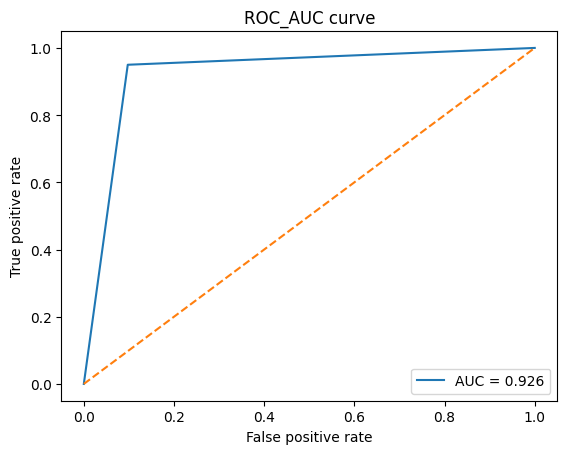

In [ ]:
# evaluating model by roc_auc curve
fpr,tpr, thresold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr,tpr)
plt.plot(fpr,tpr, label = 'AUC = %0.3f' % roc_auc)
plt.plot([0,1],[0,1],'--')
plt.title('ROC_AUC curve')
plt.legend(loc='lower right')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

In [ ]:
# test data
test_df.head()

,Patient-Uid,Date,Incident
0,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2016-12-08,SYMPTOM_TYPE_0
1,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2018-10-17,DRUG_TYPE_0
2,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2017-12-01,DRUG_TYPE_2
3,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2018-12-05,DRUG_TYPE_1
4,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2017-11-04,SYMPTOM_TYPE_0


In [ ]:
test_df.shape

(1065524, 3)

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1065524 entries, 0 to 1372859
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Patient-Uid  1065524 non-null  object        
 1   Date         1065524 non-null  datetime64[ns]
 2   Incident     1065524 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 32.5+ MB


In [ ]:
test_df.nunique()

Patient-Uid    11482
Date            1947
Incident          55
dtype: int64

In [ ]:
test_df.isnull().sum()

Patient-Uid    0
Date           0
Incident       0
dtype: int64

In [ ]:
train_df.drop_duplicates(inplace = True)

In [ ]:
test_df['Prescription_Count'] = test_df.groupby('Patient-Uid')['Date'].cumcount()
test_df['Time_diff'] = (prediction_date - test_df.groupby('Patient-Uid')['Date'].transform(max)).dt.days

In [ ]:
test_data_pred = xgb_classifier.predict(test_df[['Prescription_Count', 'Time_diff']])

In [ ]:
test_data_pred

array([0, 1, 1, ..., 1, 1, 1])

In [ ]:
# to create final submission file
Final_submission = pd.DataFrame({'Patient-Uid': test_df['Patient-Uid'], 'Prediction': test_data_pred})
Final_submission.head()

,Patient-Uid,Prediction
0,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,0
1,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,1
2,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,1
3,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,1
4,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,1


In [ ]:
Final_submission.to_csv('Final_submission.csv', index = False)